In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import importlib.util
from bayesrun.bayesflow_interface import BayesFlowInterface
import numpy as np
import bayesflow.diagnostics as diag
import pandas as pd
from matplotlib import pyplot as plt
from bayesrun.util.helper import parse_config
from torch.utils.tensorboard import SummaryWriter

2023-06-27 14:48:07.937482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 14:48:08.654817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-27 14:48:08.654876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-27 14:48:08.654883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
configfile = '/home/l/projects/BayesFlow_tumor/checkpoints/mucho_samples_y_transformer_log/20230620-174315/config.py'

In [4]:
config = parse_config(configfile)
checkpoint_dir = configfile.replace('/config.py', '')
checkpoint_folder = config.checkpoint_folder if hasattr(config, 'checkpoint_folder') else 'checkpoints'
tensorboard_folder = config.tensorboard_folder if hasattr(config, 'tensorboard_folder') else 'runs'
tensorboard_dir = checkpoint_dir.replace(checkpoint_folder, tensorboard_folder)
bayesflow_interface = BayesFlowInterface(config, checkpoint_dir=checkpoint_dir, tensorboard_dir=tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
print('Checkpoints: ' + checkpoint_dir)
print('Tensorboard: ' + tensorboard_dir)

Checkpoints: /home/l/projects/BayesFlow_tumor/checkpoints/mucho_samples_y_transformer_log/20230620-174315
Tensorboard: /home/l/projects/BayesFlow_tumor/runs/mucho_samples_y_transformer_log/20230620-174315


In [5]:
# Initialize bayesflow interface
bayesflow_interface.initialize_components()

trainer, configurator, prior = bayesflow_interface.get_trainer(), bayesflow_interface.get_configurator(), bayesflow_interface.get_prior()
summary_net, inference_net, amortizer = bayesflow_interface.get_summary_net(), bayesflow_interface.get_inference_net(), bayesflow_interface.get_amortizer()

TypeError: BayesFlowInterface.__init__() missing 1 required positional argument: 'tensorboard_dir'

In [6]:
param_names = prior.get_names()
_, test, validation = bayesflow_interface.get_data()
prior_means, prior_stds = prior.estimate_mean_and_std()

valid_sim_data_raw = test
valid_sim_data = trainer.configurator(valid_sim_data_raw)
posterior_samples = amortizer.sample(valid_sim_data, n_samples=100)
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds

100%|██████████| 1000/1000 [00:00<00:00, 3097.54it/s]
2023-06-21 08:29:14.770897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


In [7]:
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['targets'], param_names=param_names, stacked=True)
writer.add_figure('SBC_ECDF_Test', plt.gcf())

In [8]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['targets'], param_names=param_names)
writer.add_figure('Recovery', plt.gcf())

In [9]:
JagiellaTest, _, _ = bayesflow_interface.data_reader.get_data(validation_ratio=0, test_ratio=0, **{'obs_paths': ['data/no_log_observables_Jagiella2017.pkl'], 'param_paths': ['data/no_log_params_Jagiella2017.pkl'], 'profile_depth': 300})

JagiellaTest_mean = {}
JagiellaTest_mean['growth_curve'] = np.mean(JagiellaTest['growth_curve'], axis=0)
JagiellaTest_mean['sim_data'] = np.expand_dims(np.mean(JagiellaTest['sim_data'], axis=0), axis=0)
JagiellaTest_mean['prior_draws'] = np.expand_dims(JagiellaTest['prior_draws'][0], axis=0)

JagiellaTest_std = {}
JagiellaTest_std['growth_curve'] = np.std(JagiellaTest['growth_curve'], axis=0)
JagiellaTest_std['sim_data'] = np.expand_dims(np.std(JagiellaTest['sim_data'], axis=0), axis=0)
JagiellaTest_std['prior_draws'] = np.expand_dims(JagiellaTest['prior_draws'][0], axis=0)

In [10]:
JagiellaTest_sim_data_raw = JagiellaTest
JagiellaTest_sim_data = trainer.configurator(JagiellaTest_sim_data_raw)
posterior_JagiellaTest = amortizer.sample(JagiellaTest_sim_data, n_samples=100)

In [11]:
posterior_JagiellaTest_unnorm = prior_means + posterior_JagiellaTest * prior_stds
fig = diag.plot_posterior_2d(posterior_JagiellaTest_unnorm, prior_draws=valid_sim_data_raw['prior_draws'], param_names=param_names, ground_truth=JagiellaTest['prior_draws'])
writer.add_figure('Posterior2D_vs_Prior_Jagiella_corrected', plt.gcf())

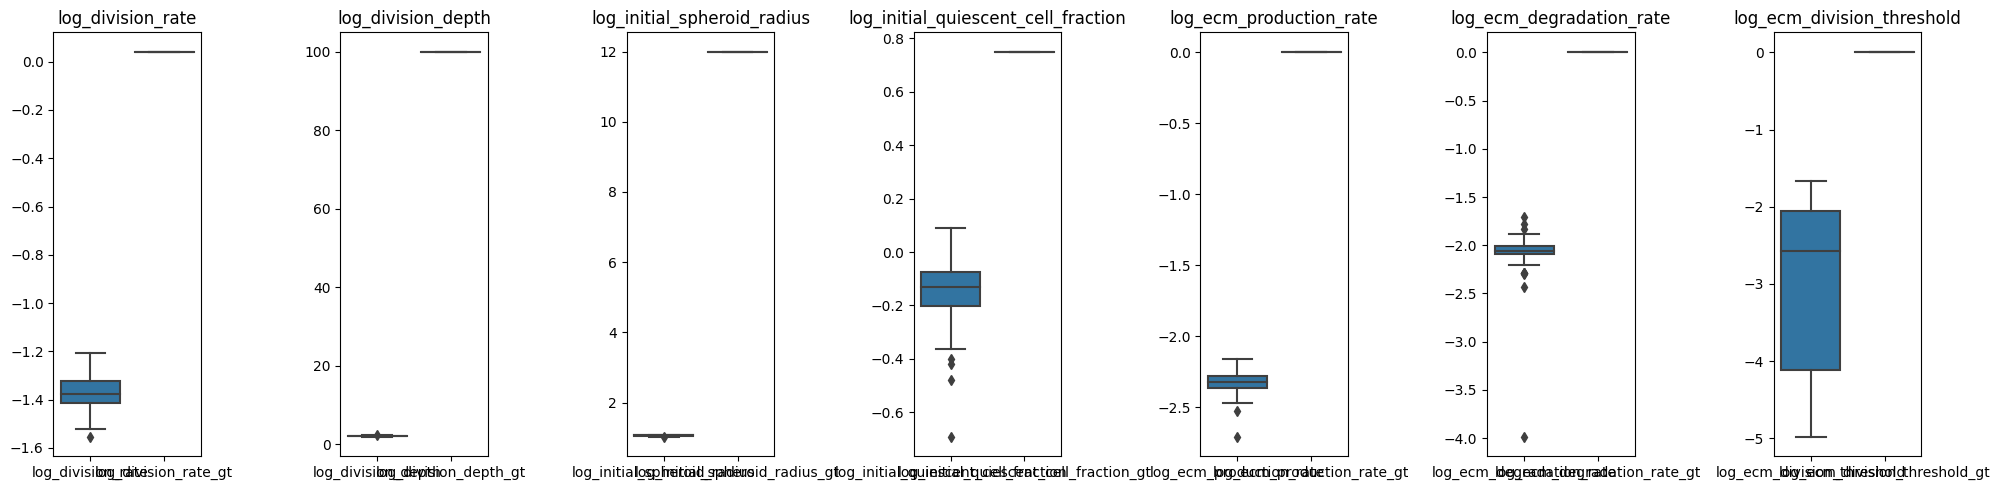

In [12]:
import seaborn as sns

df = pd.DataFrame(posterior_JagiellaTest_unnorm, columns=param_names)
for idx, p in enumerate(param_names):
    df[p + '_gt'] = JagiellaTest_sim_data_raw['prior_draws'][0][idx]
fig, axs = plt.subplots(1, len(param_names), figsize=(20, 5))
for i, param_name in enumerate(param_names):
    param = df[[param_name, param_name + '_gt']]
    sns.boxplot(param, ax=axs[i])
    axs[i].set_title(param_name)
fig.tight_layout()

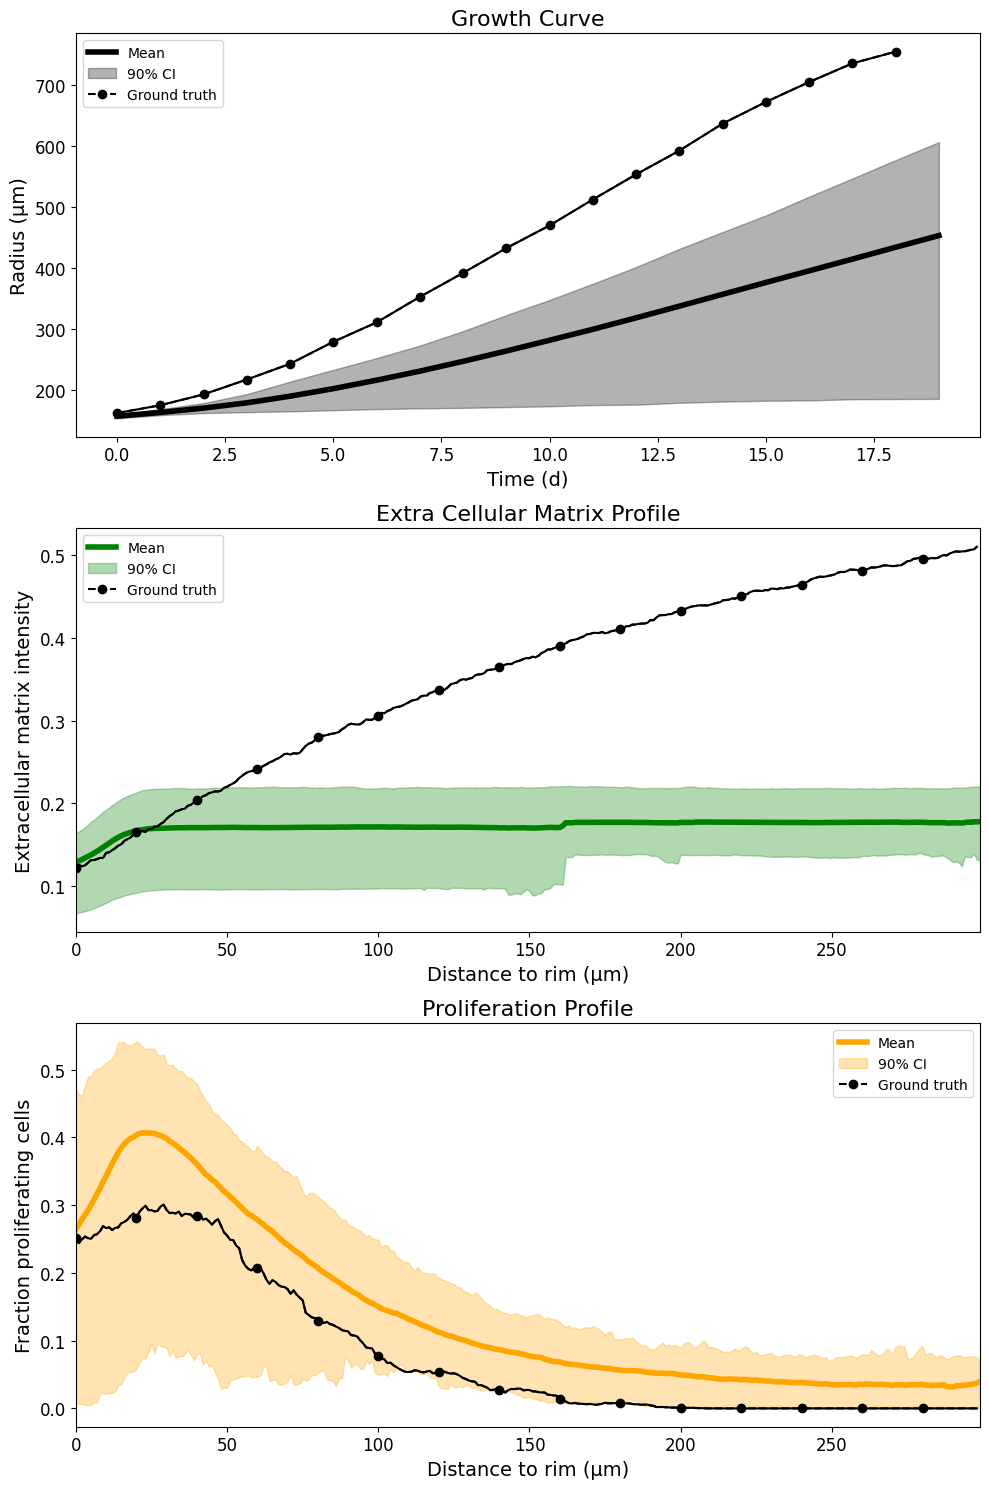

In [12]:
from string import capwords
from tumor2d import log_model
from pyabc import Parameter

profile_depth = 300

observations = []
rep = 100
for r in range(rep):
    params = {}
    for idx, p in enumerate(param_names):
        params[p] = posterior_JagiellaTest_unnorm[r][idx]
        if p == 'log_division_depth':
            params[p] = int(params[p])

    obs = log_model(Parameter(params))
    obs['extra_cellular_matrix_profile'] = obs['extra_cellular_matrix_profile'][:profile_depth]
    obs['proliferation_profile'] = obs['proliferation_profile'][:profile_depth]

    observations.append(obs)

ground_truth = pd.DataFrame({'growth_curve': [JagiellaTest_mean['growth_curve'].reshape(-1)], 'extra_cellular_matrix_profile': [JagiellaTest_mean['sim_data'][:,:,0].reshape(-1)], 'proliferation_profile': [JagiellaTest_mean['sim_data'][:,:,1].reshape(-1)]})
ground_truth_std = pd.DataFrame({'growth_curve': [JagiellaTest_std['growth_curve'].reshape(-1)], 'extra_cellular_matrix_profile': [JagiellaTest_std['sim_data'][:,:,0].reshape(-1)], 'proliferation_profile': [JagiellaTest_std['sim_data'][:,:,1].reshape(-1)]})

quantiles = {'90% CI':[0.05, 0.95]}
alpha_max = 0.3

color = {
    "growth_curve": "k",
    "extra_cellular_matrix_profile": "green",
    "proliferation_profile": "orange",
}

x_label = {
    "growth_curve": "Time (d)",
    "extra_cellular_matrix_profile": "Distance to rim (μm)",
    "proliferation_profile": "Distance to rim (μm)",
}

y_label = {
    "growth_curve": "Radius (μm)",
    "extra_cellular_matrix_profile": "Extracellular matrix intensity",
    "proliferation_profile": "Fraction proliferating cells",
}

legend_position = {
    "growth_curve": "upper left",
    "extra_cellular_matrix_profile": "upper left",
    "proliferation_profile": "upper right",
}

markevery = {
    "growth_curve": 1,
    "extra_cellular_matrix_profile": 20,
    "proliferation_profile": 20,
}

label_fontsize=14
title_fontsize=16
tick_fontsize=12
linewidth=4

obs_key = observations[0].keys()
fig, ax = plt.subplots(len(obs_key), 1)
fig.set_size_inches((10,5*len(observations[0])))

for idx, key in enumerate(obs_key):
    simulations = np.stack([o[key] if o[key][0]==0 else np.where(o[key]==0, np.nan, o[key]) for o in observations])
    mean = np.nanmean(simulations, axis=0)
    std = np.nanstd(simulations, axis=0)
    alpha_step = (alpha_max-0.1)/len(quantiles.keys())
    ax[idx].plot(range(mean.shape[0]), mean, color=color[key], linewidth=linewidth, label="Mean")
    for qidx, qkey in enumerate(quantiles.keys()):
        qt = np.nanquantile(simulations, q=quantiles[qkey], axis=0)
        ax[idx].fill_between(range(mean.shape[0]), qt[0], qt[1], color=color[key], alpha=alpha_max-(alpha_step*qidx), label=qkey)
    ax[idx].set_title(capwords(key.replace("_", " ")), fontsize=title_fontsize)
    ax[idx].set_xlabel(x_label[key], fontsize=label_fontsize)
    ax[idx].set_ylabel(y_label[key], fontsize=label_fontsize)
    ax[idx].tick_params(labelsize=tick_fontsize)
    limit = profile_depth if len(ground_truth[key][0]) > profile_depth else len(ground_truth[key][0])-1
    gt = ground_truth[key][0][:limit]
    gt_std = ground_truth_std[key][0][:limit]
    ax[idx].plot(range(gt.shape[0]), gt, linestyle='dashed', marker= 'o', color='black', label="Ground truth", markevery=markevery[key])
    ax[idx].errorbar(range(gt.shape[0]), gt, gt_std, color='black', markevery=markevery[key])
    ax[idx].legend(loc=legend_position[key])
    if key.endswith("profile"):
            ax[idx].set_xlim(0, limit)
fig.tight_layout()
writer.add_figure('Resimulation_Jagiella2017', plt.gcf())
plt.show()